# Neural Networks for Image De-noising
- Understand how multi-layer neural networks function.
- Learn about backpropagation and gradient descent algorithms.

## Theory

Assume the noisy image can be written as a matrix $P_{i}$ where each element represents the pixel intensity of the $i$ th pixel. The goal is to train a neural network $f(P; K)$ where $K$ is the known convolution kernel to output a denoised image $Q_{i} = f(P; K)$. The nodes between the inputs and the outputs are the 'hidden nodes'. All nodes have a value between 0 and 1.

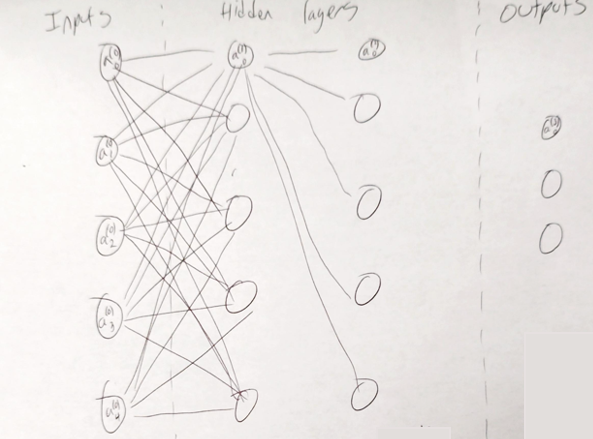

The node $a^{(1)}_0$ will have its value computed from a sum of the weighted inputs from the first layer.
$$a^{(1)}_0 = \sigma(b_0+\sum_{i} w_{i}P_{i})$$
Where $\sigma$ is the normalisation function given by $\sigma(x) = \frac{1}{1 + e^{-x}}$. $w_{i}$ are the weights associated with each input pixel $P_{i}$, $b_0$ is the bias term.

The first next layer of hidden nodes can be calculated from:

$$\mathbf{a}^{(i+1)} = \sigma(W^{(i)}\mathbf{a}^{(i)} + \mathbf{b}^{(i)})$$
 
Where $W^{(i)}$ is the weight matrix and $\mathbf{b}^{(i)}$ is the bias vector which transforms the $i$ th layer into the $i+1$ th layer. The values of $W^{(i)}$ and $\mathbf{b}^{(i)}$ are learned during training.

## Gradient Descent

The cost function measures the success of the machine learning algorithm one way it could be defined is as follows:
$$C(\mathbf{w}) = \sum_i (\hat{p}_i - p_i)^2$$
Where $\hat{p}_i$ is the estimated state from the MLP and $p_i$ is the known state. The vector $\mathbf{w}$ contains all the weights in the network. This sum is small when the network is close to being "correct".

Using gradient decent can be used to find a local minima, an optimized solution. The vector $-\Delta C(\mathbf{w})$ points in the direction of steepest decent.


## Generate test data

In [100]:
import torch
import matplotlib.pyplot as plt
from ImageDebluring import *
from torchvision import transforms


rng = torch.Generator().manual_seed(0)

def step_function(period=2.0, amplitude=0.8, y_intercept=0.0, steps=1000, x_offset=0.0):
    s = steps
    xs = torch.linspace(-5, 5, steps=s)
    ys = amplitude * torch.heaviside(torch.sin(2 * torch.pi * (xs + x_offset) / period), torch.zeros_like(xs)) + y_intercept
    return ys

def generate_random_function():
    period = 10.0
    #period = torch.rand(1, generator=rng).item() + 5
    #amplitude = torch.rand(1, generator=rng).item() * 0.1
    amplitude = 0.9
    #y_intercept = torch.rand(1, generator=rng).item() * 0.1
    y_intercept = 0.0
    x_offset = torch.rand(1, generator=rng).item() * 2*torch.pi
    #x_offset = 0.0
    return step_function(period, amplitude, y_intercept, x_offset=x_offset).unsqueeze(0).unsqueeze(0)

y = []
X = []
for i in range (10000):
    data = generate_random_function()
    degraded_data = degrade_image_1D(data, noise_scale=5000, kernel=gaussian_normalised_kernel_1D(61, 20), padding_mode='replicate')
    X.append(degraded_data.squeeze())
    y.append(data.squeeze())
    
# Make tensors
X = torch.stack(X)
y = torch.stack(y)

## Preparing the data

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(len(X_train), -1)
X_test  = torch.tensor(X_test,  dtype=torch.float32).reshape(len(X_test),  -1)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(len(y_train), -1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).reshape(len(y_test),  -1)

## Defining the MLP model
- input size for this dataset is 1000 (number of points in the 1D signal)
- hidden size can be adjusted, start with 128
- output size is also 1000 (number of points in the 1D signal)
- requires_grad=True to enable backpropagation

## Forward Pass
- Linear transformation of inputs $z^{(1)} = XW^{(1)} + b^{(1)}$
- Apply activation function $a^{(1)} = \sigma(z^{(1)})$ to node values
- Linear transformation of hidden layer $z^{(2)} = a^{(1)}W^{(2)} + b^{(2)}$
- Apply activation function $a^{(2)} = \sigma(z^{(2)})$ to get final output

## Backpropagation
- `backward` updates the weights and the baises
- `epochs` the number of times the model sees the entire dataset
- `lr` hyperparameter that controls the step size for weighted updates
- `loss` the MSE


In [102]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, m = 1):
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True) * m
        self.b1 = torch.randn(1, hidden_size, requires_grad=True) * m
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True) * m
        self.b2 = torch.randn(1, output_size, requires_grad=True) * m

    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.a1 = torch.sigmoid(self.z1) # applies sigmoid activation function
        self.z2 = torch.matmul(self.a1, self.W2) + self.b2
        self.a2 = torch.sigmoid(self.z2) 
        return self.a2
    
    def backward(self,X,y,output,lr=0.01):
        m = X.shape[0]
        dz2 = output - y
        dW2 = torch.matmul(self.a1.T, dz2)
        db2 = torch.sum(dz2, axis=0)/m
        
        da1 = torch.matmul(dz2, self.W2.T)
        dz1 = da1*(self.a1*(1-self.a1))
        dW1=torch.matmul(X.T,dz1)/m
        db1 = torch.sum(dz1, axis=0) / m
        
        with torch.no_grad():
            self.W1 -= lr * dW1
            self.b1 -= lr * db1
            self.W2 -= lr * dW2
            self.b2 -= lr * db2
            
    def train(self, X, y, epochs = 1000, lr = 0.01):
        losses = []
        for i in range(epochs):
            output = self.forward(X)
            # Compute loss using MSE
            loss = torch.mean((output - y)**2)
            losses.append(loss.item())
            # Update weights
            self.backward(X, y, output, lr)
            print(f'Epoch {i}, Loss: {loss.item()}')
        return losses
        

## Initialize model

In [103]:
input_size = 1000
hidden_size = 128
output_size = 1000
epochs = 100

model = MLP(input_size, hidden_size, output_size)
losses = model.train(X_train, y_train, epochs=epochs, lr=0.01)

Epoch 0, Loss: 0.45129963755607605
Epoch 1, Loss: 0.40627723932266235
Epoch 2, Loss: 0.27953436970710754
Epoch 3, Loss: 0.26631563901901245
Epoch 4, Loss: 0.4061056673526764
Epoch 5, Loss: 0.31482234597206116
Epoch 6, Loss: 0.265401691198349
Epoch 7, Loss: 0.26276373863220215
Epoch 8, Loss: 0.19264668226242065
Epoch 9, Loss: 0.1624126434326172
Epoch 10, Loss: 0.11485951393842697
Epoch 11, Loss: 0.099010169506073
Epoch 12, Loss: 0.06954099237918854
Epoch 13, Loss: 0.06689377874135971
Epoch 14, Loss: 0.0575459748506546
Epoch 15, Loss: 0.05709580332040787
Epoch 16, Loss: 0.05272569879889488
Epoch 17, Loss: 0.07411212474107742
Epoch 18, Loss: 0.07415115088224411
Epoch 19, Loss: 0.10902618616819382
Epoch 20, Loss: 0.08164945989847183
Epoch 21, Loss: 0.06629182398319244
Epoch 22, Loss: 0.05170749872922897
Epoch 23, Loss: 0.04753375053405762
Epoch 24, Loss: 0.04105129837989807
Epoch 25, Loss: 0.03971784934401512
Epoch 26, Loss: 0.035438600927591324
Epoch 27, Loss: 0.03297393396496773
Epoch 28

Text(0, 0.5, 'Loss')

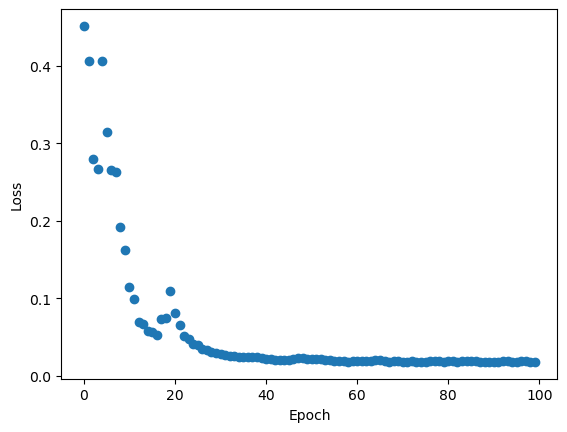

In [104]:
fig, ax = plt.subplots()
ax.scatter(range(len(losses)),  losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

tensor([1.0354e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4763e-23,
        2.8331e-34, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.5618e-38, 0.0000e+00, 2.5554e-37, 0.0000e+00, 0.0000e+00,
        2.7455e-35, 1.5016e-34, 0.0000e+00, 0.0000e+00, 1.2069e-36, 1.9644e-38,
        8.3641e-29, 3.4524e-28, 0.0000e+00, 2.2114e-37, 2.9114e-37, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2765e-38, 3.8516e-36, 1.6170e-32,
        1.4675e-31, 0.0000e+00, 0.0000e+00, 1.0191e-29, 4.4860e-33, 2.1235e-32,
        2.6109e-36, 1.5434e-20, 1.1158e-31, 3.0187e-35, 5.2926e-34, 0.0000e+00,
        6.3216e-31, 0.0000e+00, 3.5402e-26, 2.1225e-38, 3.5340e-33, 6.5280e-23,
        8.1977e-32, 2.7736e-31, 5.7952e-31, 2.8608e-30, 8.3382e-27, 8.7117e-24,
        2.7003e-30, 1.0494e-11, 9.0220e-18, 2.7370e-11, 7.2818e-12, 1.7927e-21,
        4.0461e-06, 6.9324e-08, 1.8129e-18, 1.9625e-06, 4.1908e-06, 5.8718e-07,
        4.5092e-17, 3.2897e-17, 6.0707e-

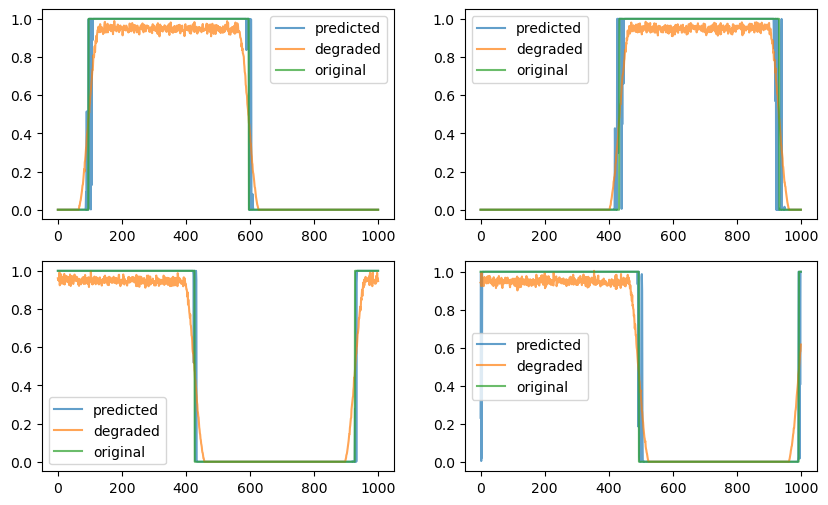

In [105]:
# randomly select 4 waves to visualise
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(2,2, figsize=(10,6))
axs = axs.flatten()
y_pred = model.forward(X_test)

for i in range (4):
    sns.lineplot(x=np.arange(len(y_pred[i])), y=y_pred[i].detach().numpy(), ax=axs[i], label='predicted', alpha = 0.7)
    sns.lineplot(x=np.arange(len(X_test[i])), y=X_test[i].numpy(), ax=axs[i], label='degraded', alpha = 0.7)
    sns.lineplot(x=np.arange(len(y_test[i])), y=y_test[i].numpy(), ax=axs[i], label='original', alpha = 0.7)
    axs[i].legend()
    print(y_pred[i])